In [2]:
import os
import numpy as np
import numpy.ma as ma
from astropy.io import ascii
from astropy.table import Table,Column,MaskedColumn
from astropy import units as u
from astropy.visualization import quantity_support
from astropy.constants import L_sun, M_sun, R_sun,sigma_sb
from math import pi
quantity_support()
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
#import pandas as pd


In [2]:
#dir = 'fits_ugriz'
#figname = "HRdiagramugriz.pdf"
#dir = 'fits_ugriz_extinction'
#output_table = 'ugriz_extinction_parameters.tab'
#figname = "HRdiagram_ugriz_extinction.pdf"
#pltitle = 'Fitted vs. Observed Spectral Types for ugriz with extinction of SDSS Standard Stars'
dir = 'fits_ugrizJHK_extinction'
output_table = 'ugrizJHK_extinction_parameters.tab'
figname = "HRdiagram_ugrizJHK_extinction.pdf"
pltitle = 'Fitted vs. Observed Spectral Types for ugriz+JHK with extinction of SDSS Standard Stars'

#dir = 'fits_UBVRIJHK_extinction'
#figname = "HRdiagram_UBVRIJHK_extinction.pdf"
#output_table ='UBVRIJHK_extinction_parameters.tab'
#pltitle = 'Fitted vs. Observed Spectral Types for UBVRIJHK with extinction of SDSS Standard Stars'

#dir = 'fits_gaia2rjhk_extinction'
#figname = "HRdiagram_gaia2rjhk_extinction.pdf"
#output_table = 'gaia2rJHK_extinction_parameters.tab'
#pltitle = 'Fitted vs. Observed Spectral Types for GAIA2r+JHK with extinction of SDSS Standard Stars'

#dir = 'fits_gaia2jhk_extinction'
#figname = "HRdiagram_gaia2jhk_extinction.pdf"
#output_table = 'gaia2JHK_extinction_parameters.tab'
#pltitle = 'Fitted vs. Observed Spectral Types for GAIA2+JHK with extinction of SDSS Standard Stars'

In [3]:
def getcolor(si):
    if si == "N/A": return 'black'
    if si.startswith("O") or si.startswith("sdO"): return 'gray'
    if si.startswith("B") or si.startswith("sdB"): return 'blue'
    if si.startswith("A") or si.startswith("sdA"): return 'cyan'
    if si.startswith("F") or si.startswith("sdF"): return 'gold'
    if si.startswith("G") or si.startswith("sdG"): return 'green'
    if si.startswith("K") or si.startswith("sdK"): return 'darkorange'
    if si.startswith("M") or si.startswith("sdM"): return 'red'
    if si.startswith("DA"): return'purple'
    return 'black'


def getlumclassmarker(si):
    if si.endswith("I"): return "D"
    if si.endswith("II"): return "v"
    if si.endswith("III"): return "^"
    if si.endswith("IV"): return "+"
    if si.endswith("V") or si[-1].isdigit(): return "o"
    if si.endswith("VI") or si.startswith("sd"): return "s"
    if si.endswith("VII") or si.startswith("DA"): return "*"
    return "x"

def getlumclass(si):
    if si.endswith("I"): return "I"
    if si.endswith("III"): return "III"
    if si.endswith("II"): return "II"
    if si.endswith("IV"): return "IV"
    if si.endswith("V") or si[-1].isdigit(): return "V"
    if si.endswith("VI") or si.startswith("sd"): return "VI"
    if si.endswith("VII") or si.startswith("DA"): return "VII"
    return "x"

def has_spcolor(si):
    c = getlumclass(si)
    return c == "V" or c == "I" or c == "III"

lu = dict()
lu['D'] = 'I - supergiants'  
lu['v'] = 'II - bright giants'
lu['^'] = 'III - giants'
lu['+'] = 'IV - subgiants'
lu['o'] = 'V - main sequence'
lu['s'] = 'VI - subdwarfs'
lu['*'] = 'VII - white dwarfs'
lu['x'] = 'other'

In [4]:

input_files = []
colvalues=[]
colnames = []
for file in os.listdir(dir):
    if file.endswith(".txt"):
        fname = os.path.join(dir, file)
        input_files.append(fname)
# get the headers
f = open(input_files[0],'r')
z= f.readline().split()
colnames.extend(z)
z= f.readline().split()
colnames.extend(z)
# get junk line
f.readline()
colvalues.extend(f.readline().split())
colvalues.extend(f.readline().split())
f.close()
colunits = ['' for x in colvalues]
colunits[6] = 'mag'
# another way
x = colvalues[8]*u.solRad
colvalues[8] = x.decompose().scale
#colvalues[8] *= R_sun
#colvalues[8] = colvalues[8].value
print(type(colvalues[8]))
colunits[8] = 'm'
colunits[9]  = 'K'
colunits[11] = 'degree'
coldtypes=[np.dtype(np.object),np.dtype(np.int32),np.dtype(np.int32),np.dtype(np.int32),np.dtype(np.object),np.dtype(np.float),np.dtype(np.float),np.dtype(np.float),np.dtype(np.float),np.dtype(np.float),np.dtype(np.float),np.dtype(np.float)]
coldesc = ['name', 'number of fit points', 'number of fits', 'fit number','best fit model', 'goodness of fit', 'extinction', 'scale factor', 'stellar radius', 'stellar temperature', 'scattering', 'viewing angle']
for i in range(len(colnames)):
  print('%s %s %s %s %s'% (colnames[i],colvalues[i],colunits[i],coldtypes[i],coldesc[i]))



<class 'float'>
source_name PG0918+029D  object name
n_data 16  int32 number of fit points
n_fits 1  int32 number of fits
fit_id 1  int32 fit number
model_name muZ1DMfw_01  object best fit model
chi2 28362.101  float64 goodness of fit
av 0.064 mag float64 extinction
scale 0.153  float64 scale factor
star.radius 5782658400.0 m float64 stellar radius
star.temperature 4.688e+03 K float64 stellar temperature
scattering 1.000e+00  float64 scattering
inclination 4.500e+01 degree float64 viewing angle


In [5]:
t = Table(names=colnames,dtype=coldtypes,masked=True)
#t.add_row(colvalues)
#for i in range(len(colnames)):
#   c = Column([colvalues[i]],unit=colunits[i],description=coldesc[i])
#   t[colnames[i]] = c
#   print(colnames[i])
#print(t['chi2'])
for i in range(len(colnames)):
    t[colnames[i]].unit = colunits[i]
for i in range(0,len(input_files)):
    f = open(input_files[i],'r')
    f.readline()
    f.readline()
    f.readline()
    colvalues=[]
    colvalues.extend(f.readline().split())
    if(colvalues[-1] == '0'): continue
    #print("%s %s"%(input_files[i],colvalues[-1]))
    colvalues.extend(f.readline().split())  
    #print("%s %d"%(input_files[i],len(colvalues)))
    x = colvalues[8]*u.solRad
    colvalues[8] = x.decompose().scale
    #colvalues[8] = float(colvalues[8])*R_sun
    #print(colvalues[8],x)
    #colvalues[8] = colvalues[8].value
    t.add_row(colvalues)
    f.close()
t.add_index('source_name')
#t.loc['BD+2_3375']['star.radius']
#t.show_in_notebook(display_length=20)

In [6]:
#print(t['star.radius'])
t['star.luminosity'] = 4.0*pi*sigma_sb*(t['star.radius']**2)*(t['star.temperature']**4)
t['star.Lsun'] = t['star.luminosity']/L_sun
t['star.luminosity'].unit = 'W'
t['star.luminosity'].format='4.3E'
t['star.radius'].format='4.3E'
t['star.Lsun'].unit='Lsun'
t['star.Lsun'].format='5.3f'
t['star.Rsun'] = t['star.radius']/R_sun # yes I know...
t['star.Rsun'].unit='Rsun'
t['star.Rsun'].format='5.3f'

#print(L_sun)
#print(1*u.solRad.decompose().scale)
#print((4*pi*sigma_sb*(R_sun**2)*(5830*u.K)**4)/L_sun)

t['star.SpType'] = Column(name='star.SpType',length=len(t),dtype=np.object)
#t['B_V'] = Column(length=len(t),dtype=np.float)
#t['B_V_ERROR'] = Column(length=len(t),dtype=np.float)
standards = Table.read("sdss_standards.votab")
standards.show_in_notebook(display_length=2)
sptype = []
standards.add_index('StarName')
for sj in t['source_name']:
    spacename = sj.replace('_',' ')
    z = standards.loc[spacename]['SpType']
    #t.loc[sj]['B_V'] = standards.loc[spacename]['B_V'] 
    #t.loc[sj]['B_V_ERROR'] = standards.loc[spacename]['B_V_ERROR'] 
    t.loc[sj]['star.SpType']= z.replace(":","")
#    print(standards.loc[spacename]['SpType'],standards.loc[spacename]['MK_Spectral_type'])
t.show_in_notebook(display_length=2)
#standards.show_in_notebook(display_length=5)


idx,source_name,n_data,n_fits,fit_id,model_name,chi2,av,scale,star.radius,star.temperature,scattering,inclination,star.luminosity,star.Lsun,star.Rsun,star.SpType
,,,,,,,mag,,m,K,,deg,W,solLum,solRad,
0,PG0918+029D,16,1,1,muZ1DMfw_01,28362.101,0.064,0.153,5.783E+09,4688.0,1.0,45.0,1.151E+28,30.065,8.312,N/A
1,PG1323-086D,16,1,1,OsOd6eo9_01,127270.155,1.455,-0.57,5.861E+08,8128.0,1.0,45.0,1.068E+27,2.791,0.843,N/A
2,PG2336+004B,16,1,1,CHRkAYe4_01,55998.946,0.416,-0.346,7.931E+08,6742.0,1.0,45.0,9.260E+26,2.419,1.140,N/A
3,Ru_149F,16,1,1,VBuU92yL_01,37507.418,0.0,0.543,7.945E+09,4674.0,1.0,45.0,2.147E+28,56.076,11.420,N/A
4,SA_100_241,16,1,1,RPeWZ4ls_01,41298.124,0.0,-0.316,1.480E+09,7906.0,1.0,45.0,6.096E+27,15.924,2.127,A3
5,SA_101_207,16,1,1,uhnlg6ZT_01,40819.476,0.0,-0.272,9.684E+08,6109.0,1.0,45.0,9.307E+26,2.431,1.392,F8
6,SA_101_315,16,1,1,9GXHxI7x_01,48091.127,0.0,-0.147,4.783E+09,4570.0,1.0,45.0,7.110E+27,18.574,6.875,K0III
7,SA_101_316,16,1,1,VRgt2o6W_01,78343.094,0.0,-0.184,1.330E+09,6865.0,1.0,45.0,2.800E+27,7.315,1.912,F6
8,SA_103_626,16,2,1,0TouQGQi_01,17510.084,0.0,-0.151,1.318E+09,6788.0,1.0,45.0,2.629E+27,6.869,1.895,F3


In [7]:
classes = []
colors = []
for j in t['star.SpType']:
    #print(j)
    colors.append(getcolor(j))
    classes.append(getlumclassmarker(j))

In [8]:

t.write(output_table,format='votable',overwrite=True)


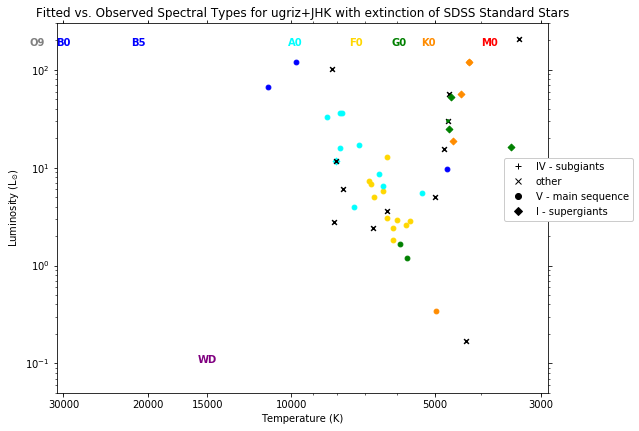

In [9]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [8.8,6.8]
import matplotlib.ticker
for x,y,c,m in zip(t['star.temperature'],t['star.Lsun'],colors,classes):
#plt.scatter((t['star.temperature']),(t['star.Lsun']),c=colors,s=10,marker=classes)
    plt.scatter(x,y,c=c,s=23,marker=m)
plt.xlim(2900,31000)
plt.ylim(0.05,300)
plt.xlabel("Temperature (K)")
plt.ylabel("Luminosity (L$_{\odot}$)")
ax = plt.gca()
ax.invert_xaxis()
plt.text(34000,175,"O9",horizontalalignment='center',color=getcolor("O"),weight='bold')
plt.text(30000,175,"B0",horizontalalignment='center',color=getcolor("B"),weight='bold')
plt.text(20900,175,"B5",horizontalalignment='center',color=getcolor("B"),weight='bold')
plt.text(9790,175,"A0",horizontalalignment='center',color=getcolor("A"),weight='bold')
plt.text(7300,175,"F0",horizontalalignment='center',color=getcolor("F"),weight='bold')#,backgroundcolor='gray')
plt.text(5940,175,"G0",horizontalalignment='center',color=getcolor("G"),weight='bold')
plt.text(5150,175,"K0",horizontalalignment='center',color=getcolor("K"),weight='bold')
plt.text(3840,175,"M0",horizontalalignment='center',color=getcolor("M"),weight='bold')
plt.text(15000,0.1,"WD",horizontalalignment='center',color=getcolor("DA"),weight='bold')

ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xticks([3000,5000,10000,15000,20000,30000])
ax.tick_params(bottom=True,top=True,left=True,right=True)
ax.tick_params(top=True, which="minor",axis="x")
ax.tick_params(right=True, which="minor",axis="y")

ax.get_xaxis().set_major_formatter(ScalarFormatter())
#ax.get_xaxis().set_minor_formatter(ScalarFormatter())
cu = list(set(classes))
#print(cu)
plt.title(pltitle)
patches = [plt.plot([],[],marker=z,ls="",color='black',label=lu[z])[0] for z in cu]
plt.legend(handles=patches,loc='best',numpoints=1,ncol=1, bbox_to_anchor=(.9,0.65),framealpha=1)
plt.savefig(figname)


In [5]:
trobi = Table.read('/n/subaruraid/mpound/sedfittermodels/models_r17/s---s-i/parameters.fits')

In [6]:
trobi[:15]

MODEL_NAME,star.radius,star.temperature,scattering,inclination
bytes20,float64,float64,int64,float64
01QyhoBc_01,0.2728,4888.0,1,45.0
01Xx6elC_01,0.383,12050.0,1,45.0
03ZZRVTe_01,31.22,4967.0,1,45.0
03amqKIp_01,13.81,7891.0,1,45.0
03dloFhH_01,44.63,6450.0,1,45.0
03jGXYVQ_01,4.797,9889.0,1,45.0
05DVDxNM_01,0.6069,4998.0,1,45.0
05qQySTl_01,8.242,7737.0,1,45.0
05tRaRtL_01,50.31,6017.0,1,45.0


In [7]:
trobistar=Table.read('/n/subaruraid/mpound/sedfittermodels/models_r17/s---s-i/stellar.fits')

In [8]:
trobistar[0:15]

MODEL_NAME
bytes20
01QyhoBc_01
01Xx6elC_01
03ZZRVTe_01
03amqKIp_01
03dloFhH_01
03jGXYVQ_01
05DVDxNM_01
05qQySTl_01
05tRaRtL_01


In [9]:
tsources = Table.read("sdss_standards+gaia.votab")

In [17]:
np.min(tsources["rms_z"])

0.0017320508075688774

(array([31., 36., 54., 16.,  9.,  2.,  2.,  2.,  2.,  2.]),
 array([0.00173205, 0.00337268, 0.00501331, 0.00665394, 0.00829457,
        0.0099352 , 0.01157583, 0.01321647, 0.0148571 , 0.01649773,
        0.01813836]),
 <a list of 10 Patch objects>)

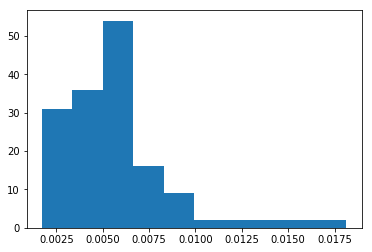

In [14]:
plt.hist(tsources["rms_z"])

In [18]:
tyso = Table.read("SerpensNE_YSOs.tbl",format='ipac')

In [19]:
len(tyso)

172

In [20]:
tyso[:10]

GBS_ID,ra,D_ra,dec,D_dec,Q_pos,Q_merge,id2mass,Prob_Galc,alpha,D_alpha,alpha_chi2,alpha_nfit,object_type,Av,D_Av,mag_IR1,D_mag_IR1,Av_chi2,Av_nfit,J_flux_c,J_D_flux_c,J_date_c,J_Q_det_c,H_flux_c,H_D_flux_c,H_date_c,H_Q_det_c,Ks_flux_c,Ks_D_flux_c,Ks_date_c,Ks_Q_det_c,IR1_flux_1,IR1_D_flux_1,IR1_date_1,IR1_Q_det_1,IR1_flux_2,IR1_D_flux_2,IR1_date_2,IR1_Q_det_2,IR1_flux_c,IR1_D_flux_c,IR1_date_c,IR1_Q_det_c,IR1_Q_flux_m,IR1_imtype,IR1_src_area,IR1_amajor,IR1_aminor,IR1_tilt,IR2_flux_1,IR2_D_flux_1,IR2_date_1,IR2_Q_det_1,IR2_flux_2,IR2_D_flux_2,IR2_date_2,IR2_Q_det_2,IR2_flux_c,IR2_D_flux_c,IR2_date_c,IR2_Q_det_c,IR2_Q_flux_m,IR2_imtype,IR2_src_area,IR2_amajor,IR2_aminor,IR2_tilt,IR3_flux_1,IR3_D_flux_1,IR3_date_1,IR3_Q_det_1,IR3_flux_2,IR3_D_flux_2,IR3_date_2,IR3_Q_det_2,IR3_flux_c,IR3_D_flux_c,IR3_date_c,IR3_Q_det_c,IR3_Q_flux_m,IR3_imtype,IR3_src_area,IR3_amajor,IR3_aminor,IR3_tilt,IR4_flux_1,IR4_D_flux_1,IR4_date_1,IR4_Q_det_1,IR4_flux_2,IR4_D_flux_2,IR4_date_2,IR4_Q_det_2,IR4_flux_c,IR4_D_flux_c,IR4_date_c,IR4_Q_det_c,IR4_Q_flux_m,IR4_imtype,IR4_src_area,IR4_amajor,IR4_aminor,IR4_tilt,MP1_flux_1,MP1_D_flux_1,MP1_date_1,MP1_Q_det_1,MP1_flux_2,MP1_D_flux_2,MP1_date_2,MP1_Q_det_2,MP1_flux_c,MP1_D_flux_c,MP1_date_c,MP1_Q_det_c,MP1_Q_flux_m,MP1_imtype,MP1_src_area,MP1_amajor,MP1_aminor,MP1_tilt,MP2_flux_1,MP2_D_flux_1,MP2_date_1,MP2_Q_det_1,MP2_flux_2,MP2_D_flux_2,MP2_date_2,MP2_Q_det_2,MP2_flux_c,MP2_D_flux_c,MP2_date_c,MP2_Q_det_c,MP2_Q_flux_m,MP2_imtype,MP2_src_area,MP2_amajor,MP2_aminor,MP2_tilt
,deg,deg,deg,deg,,,,,,,,,,,,,,,,mJy,mJy,dateTtime,,mJy,mJy,dateTtime,,mJy,mJy,dateTtime,,mJy,mJy,dateTtime,,mJy,mJy,dateTtime,,mJy,mJy,dateTtime,,,,pixel_sq,pixels,pixels,deg,mJy,mJy,dateTtime,,mJy,mJy,dateTtime,,mJy,mJy,dateTtime,,,,pixel_sq,pixels,pixels,deg,mJy,mJy,dateTtime,,mJy,mJy,dateTtime,,mJy,mJy,dateTtime,,,,pixel_sq,pixels,pixels,deg,mJy,mJy,dateTtime,,mJy,mJy,dateTtime,,mJy,mJy,dateTtime,,,,pixel_sq,pixels,pixels,deg,mJy,mJy,dateTtime,,mJy,mJy,dateTtime,,mJy,mJy,dateTtime,,,,pixel_sq,pixels,pixels,deg,mJy,mJy,dateTtime,,mJy,mJy,dateTtime,,mJy,mJy,dateTtime,,,,pixel_sq,pixels,pixels,deg
str25,float64,float64,float64,float64,str1,str1,str16,float64,float64,float64,float64,int64,str19,float64,float64,float64,float64,float64,int64,float64,float64,str19,str1,float64,float64,str19,str1,float64,float64,str19,str1,float64,float64,str23,str1,float64,float64,str23,str1,float64,float64,str23,str1,str1,int64,float64,float64,float64,float64,float64,float64,str23,str1,float64,float64,str23,str1,float64,float64,str23,str1,str1,int64,float64,float64,float64,float64,float64,float64,str23,str1,float64,float64,str23,str1,float64,float64,str23,str1,str1,int64,float64,float64,float64,float64,float64,float64,str23,str1,float64,float64,str23,str1,float64,float64,str23,str1,str1,int64,float64,float64,float64,float64,float64,float64,str23,str1,float64,float64,str23,str1,float64,float64,str23,str1,str1,int64,float64,float64,float64,float64,float64,float64,str4,str1,float64,float64,str4,str1,float64,float64,str23,str1,str1,int64,float64,float64,float64,float64
SSTGBS J183608.5+000205,279.0353208,5.56e-07,0.0345973,5.56e-07,A,A,18360847+0002046,-1.91,-1.42,0.0526,34.1,6,YSOc_star+dust(MP1),11.11,1.1,11.23,0.0986,1.47,7,3.26,0.0841,1999-04-18T21:47:48,A,5.9,0.114,1999-04-18T21:47:48,A,5.37,0.129,1999-04-18T21:47:48,A,4.37,0.213,2007-05-15T20:03:12.871,A,4.16,0.202,2007-05-15T20:03:12.871,A,4.26,0.203,2007-05-15T20:03:12.871,A,A,1,3.09,1.5,1.5,-45.0,3.3,0.165,2007-05-15T20:03:12.871,A,3.02,0.155,2007-05-15T20:03:12.871,A,3.15,0.155,2007-05-15T20:03:12.871,A,A,1,2.97,1.7,1.7,-45.0,2.47,0.137,2007-05-15T20:03:12.871,A,2.28,0.123,2007-05-15T20:03:12.871,A,2.38,0.121,2007-05-15T20:03:12.871,A,A,1,3.92,1.8,1.8,-45.0,1.66,0.125,2007-05-15T20:03:12.871,A,1.52,0.119,2007-05-15T20:03:12.871,A,1.62,0.1,2007-05-15T20:03:12.871,A,A,1,4.98,1.8,1.8,-45.0,3.84,0.486,2007-09-28T21:08:48.072,A,3.81,0.431,2007-09-28T16:04:36.638,A,3.75,0.405,2007-09-28T18:36:42.355,A,A,